## Persistence Landscapes

- vectorized representations of persistence diagrams

- per homology group rank (ex H0, H1, or H2)
- per stimuli
- per region
- difference landscapes

Author: @emilyekstrum
<br> 11/17/25

In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from persim import PersLandscapeApprox
from persim import persistent_entropy
from persim.landscapes import average_approx
from persim.landscapes import snap_pl
from persim.landscapes import plot_landscape_simple
from persim.landscapes import plot_landscape
import random
import os
from matplotlib.lines import Line2D
import numpy as np
from typing import Optional, Tuple, Sequence, Any
from sklearn.decomposition import PCA
from ripser import ripser
from persim import wasserstein
from sklearn.neighbors import NearestNeighbors    
from scipy.sparse import coo_matrix    


In [2]:
# Import TDA utilities
import sys
from pathlib import Path

# Add the repo root to path if needed
repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

try:
    from tda_utils import TDADataManager, tda_manager
    print("TDA utilities loaded")
except ImportError as e:
    print(f"Could not import TDA utilities: {e}")
    print("Make sure you're running from the TDA repository.")
    raise

# Initialize or use the global data manager
if tda_manager is not None:
    data_manager = tda_manager
else:
    data_manager = TDADataManager()

# Print summary of available data
data_manager.print_summary()

Data already available.
TDA utilities loaded
TDA Data Manager Summary
Workspace root: /Users/emilyekstrum/repos/TDA
Data directory: /Users/emilyekstrum/repos/TDA/data
  - clean_spike_data_zip: clean_spike_data.zip
  - clean_spike_data_dir: clean_spike_data
      Contains 8 .pkl files
  - cebra_examples: CEBRA_embedding_examples
      Contains 4 .pkl files
  - persistence_examples: persistence_diagram_examples
      Contains 22 .pkl files

Available spike datasets (8):
  • LGNchromatic_gratings.pkl
  • LGNcolor_exchange.pkl
  • LGNdrifting_gratings.pkl
  • LGNluminance_flash.pkl
  • V1chromatic_gratings.pkl
  and 3 more


# for plots
- x axis = filtration parameter (midpoint of feature (death - birth)/2)
- y axis = "feature persistence strength" (half-life of feature (birth+death)/2)

In [3]:
# data directory setup using TDA utilities
data_dir = data_manager.data_paths['persistence_examples']
print(f"Using persistence diagrams from: {data_dir}")

stim_map = {
    "dg": "drifting_gratings",
    "cg": "chromatic_gratings",
    "cex": "color_exchange",
    "lf": "luminance_flash",
}

def parse_filename(fname: str):
    """ Parse filename to get method, embed_dim, region, stim, mouse using TDA utilities.
    
    Args:
        fname (str): filename
    Returns:
        dict: method, embed_dim, region, stim, mouse"""

    # TDA utilities for parsing
    info = data_manager.parse_filename_info(fname)
    
    return {
        "method": "CEBRA",  
        "embed_dim": info['dimension'],
        "region": info['region'],
        "stim": info['stimulus'],
        "mouse": info['mouse_id'],
    }

def load_dgms(path: str):
    """ Load diagrams from pickle file using TDA utilities.
    
    Args:
        path (str): path to pickle file
    Returns:
        list: diagrams"""

    return data_manager.load_persistence_diagrams(path)

Using persistence diagrams from: /Users/emilyekstrum/repos/TDA/data/persistence_diagram_examples


In [5]:
available_files = data_manager.find_files("*.pkl", "persistence_examples")

if available_files:
    print(f"{len(available_files)} persistence diagram files")
    
    # organize by region and stimulus
    file_organization = {}
    for file_path in available_files:
        info = data_manager.parse_filename_info(file_path)
        region = info['region']
        stimulus = info['stimulus']
        
        key = f"{region}_{stimulus}"
        if key not in file_organization:
            file_organization[key] = []
        file_organization[key].append(file_path)
    
    print(f"\nAvailable data files:")
    for combo, files in file_organization.items():
        region, stim = combo.split('_', 1)
        print(f"  • {region} - {stim.replace('_', ' ').title()}: {len(files)} files")
        
    # lists for each region
    LGN_files = [f.name for f in available_files if data_manager.parse_filename_info(f)['region'] == 'LGN']
    V1_files = [f.name for f in available_files if data_manager.parse_filename_info(f)['region'] == 'V1']

    
else:
    print("No persistence diagram files found.")
    print("Please run the Ripser notebook first to generate persistence diagrams.")
    LGN_files = []
    V1_files = []

22 persistence diagram files

Available data files:
  • V1 - Color Exchange: 14 files
  • LGN - Color Exchange: 8 files


## By region

In [7]:
# average landscapes for each homology group (H0, H1, H2)
if available_files:
    
    avg_lgn_landscapes = {}
    avg_v1_landscapes = {}

    for hom_deg in range(3): 
        print(f"  Processing H{hom_deg}")
        LGN_landscape = []
        V1_landscape = []
        
        # LGN files
        lgn_count = 0
        for f in LGN_files:
            try:
                fpath = data_dir / f
                dgms = load_dgms(fpath)
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                if dgms and len(dgms) > hom_deg:
                    if dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                        persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                        LGN_landscape.append(persistence_landscape)
                        lgn_count += 1
            except Exception as e:
                print(f"    Error processing {f}: {e}")
                continue
        
        # V1 files
        v1_count = 0
        for f in V1_files:
            try:
                fpath = data_dir / f
                dgms = load_dgms(fpath)
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                if dgms and len(dgms) > hom_deg:
                    if dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                        persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                        V1_landscape.append(persistence_landscape)
                        v1_count += 1
            except Exception as e:
                print(f"    Error processing {f}: {e}")
                continue
        
        # Average persistence landscapes 
        if LGN_landscape:
            avg_lgn_landscapes[f'H{hom_deg}'] = average_approx(LGN_landscape)
            print(f"    LGN H{hom_deg}: {lgn_count} landscapes averaged")
        if V1_landscape:
            avg_v1_landscapes[f'H{hom_deg}'] = average_approx(V1_landscape)
            print(f"    V1 H{hom_deg}: {v1_count} landscapes averaged")

    # Store individual landscape variables
    avg_lgn_h0_landscape = avg_lgn_landscapes.get('H0')
    avg_lgn_h1_landscape = avg_lgn_landscapes.get('H1')
    avg_lgn_h2_landscape = avg_lgn_landscapes.get('H2')
    avg_v1_h0_landscape = avg_v1_landscapes.get('H0')
    avg_v1_h1_landscape = avg_v1_landscapes.get('H1')
    avg_v1_h2_landscape = avg_v1_landscapes.get('H2')
    
else:
    print("No files available for landscape computation.")

  Processing H0
    LGN H0: 8 landscapes averaged
    V1 H0: 14 landscapes averaged
  Processing H1
    LGN H1: 8 landscapes averaged
    V1 H1: 14 landscapes averaged
  Processing H2
    LGN H2: 8 landscapes averaged
    V1 H2: 14 landscapes averaged


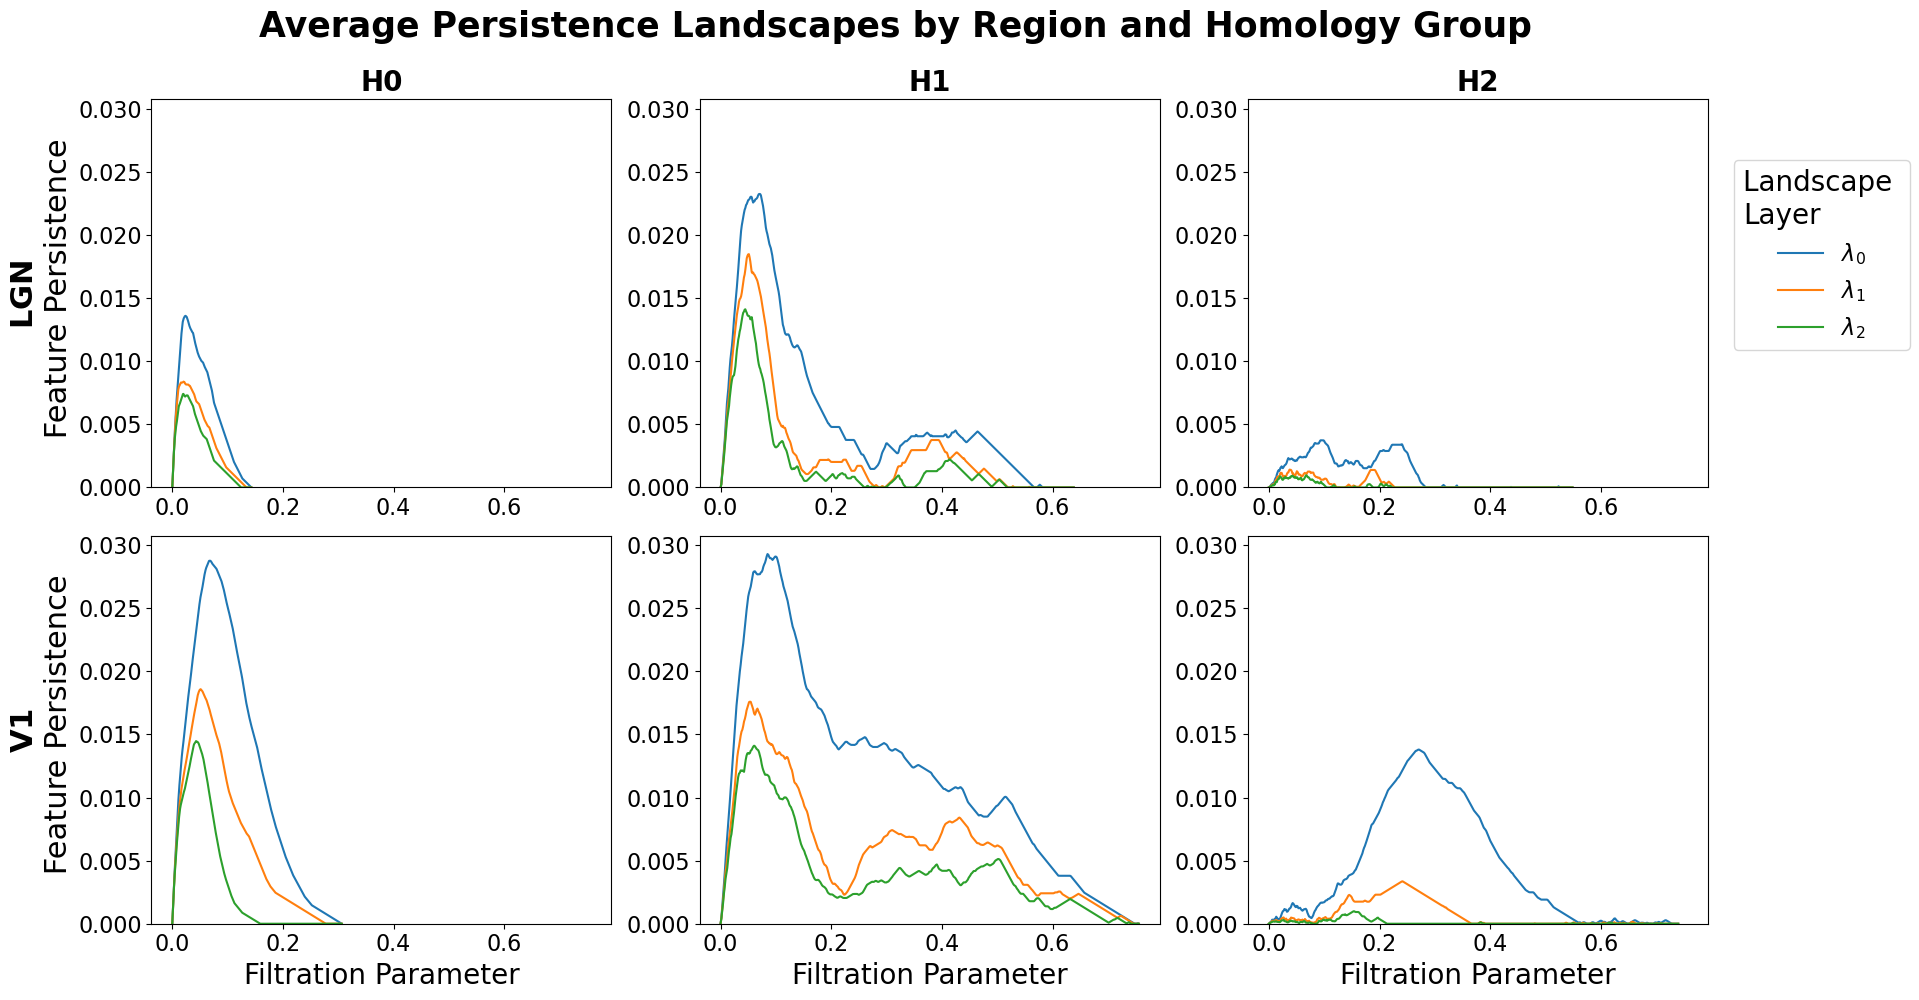

In [ ]:
# Plot average persistence landscapes for V1 and LGN for each homology group
if available_files and avg_lgn_landscapes and avg_v1_landscapes:
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # landscapes and labels
    landscapes = {
        'LGN': {
            'H0': avg_lgn_h0_landscape,
            'H1': avg_lgn_h1_landscape,
            'H2': avg_lgn_h2_landscape
        },
        'V1': {
            'H0': avg_v1_h0_landscape,
            'H1': avg_v1_h1_landscape,
            'H2': avg_v1_h2_landscape
        }
    }

    homology_groups = ['H0', 'H1', 'H2']
    regions = ['LGN', 'V1']

    def count_valid_diagrams(file_list, hom_deg):
        """ Count diagrams in a list of files

        Args:
            file_list (list): list of file names
            hom_deg (int): homology group degree

        Returns:
            int: number of valid diagrams"""

        count = 0
        for fname in file_list:
            try:
                fpath = data_dir / fname
                dgms = load_dgms(fpath)
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                if dgms and len(dgms) > hom_deg:
                    dgm = dgms[hom_deg]
                    if dgm is not None and len(dgm) > 0:
                        count += 1
            except Exception:
                continue
        return count

    diagram_counts = {
        'LGN': {group: count_valid_diagrams(LGN_files, int(group[1])) for group in homology_groups},
        'V1': {group: count_valid_diagrams(V1_files, int(group[1])) for group in homology_groups}
    }

    # calculate global x and y limits across all landscapes
    all_x_values = []
    all_y_values = []

    for region in regions:
        for group in homology_groups:
            landscape = landscapes[region][group]
            if landscape is None:
                continue
            try:
                xs = landscape.grid
            except AttributeError:
                try:
                    xs = landscape.xs
                except AttributeError:
                    xs = np.linspace(landscape.start, landscape.stop, landscape.num_steps)
            
            try:
                landscapes_data = landscape.landscapes
            except AttributeError:
                try:
                    landscapes_data = landscape.values
                except AttributeError:
                    landscapes_data = landscape.Ls
            
            all_x_values.extend(xs)
            # Get y values from first 10 lambda function
            n_layers = min(10, len(landscapes_data))
            for i in range(n_layers):
                all_y_values.extend(landscapes_data[i])

    # Calculate global limits
    if all_x_values and all_y_values:
        x_min = min(all_x_values)
        x_max = max(all_x_values)
        y_min = min(all_y_values)
        y_max = max(all_y_values)

        # Add small padding
        x_padding = (x_max - x_min) * 0.05
        y_padding = (y_max - y_min) * 0.05
        x_min -= x_padding
        x_max += x_padding
        y_min = max(0, y_min - y_padding)  # Don't go below 0 for y
        y_max += y_padding

        # Plot landscapes using plot_landscape_simple()
        for row_idx, region in enumerate(regions):
            for col_idx, group in enumerate(homology_groups):
                ax = axes[row_idx, col_idx]
                landscape = landscapes[region][group]
                
                if landscape is not None:
                    # Set current axes and plot using plot_landscape_simple()
                    plt.sca(ax)
                    try:
                        plot_landscape_simple(landscape, title="", depth_range=range(3))
                        
                        # Remove legend from individual subplot
                        legend = ax.get_legend()
                        if legend:
                            legend.remove()
                        
                        # Set the same axis limits for all subplots
                        ax.set_xlim(x_min, x_max)
                        ax.set_ylim(y_min, y_max)
                    except Exception as e:
                        print(f"Error plotting {region} {group}: {e}")
                        ax.text(0.5, 0.5, f'No data\n{region} {group}', 
                               transform=ax.transAxes, ha='center', va='center')
                else:
                    ax.text(0.5, 0.5, f'No data\n{region} {group}', 
                           transform=ax.transAxes, ha='center', va='center')
                
                ax.tick_params(axis='x', labelsize=16) 
                ax.tick_params(axis='y', labelsize=16)

                # Set labels
                if row_idx == 0:
                    ax.set_title(
                        f"{homology_groups[col_idx]}",
                        fontsize=20,
                        fontweight='bold'
                    )
                if col_idx == 0:
                    ax.set_ylabel(f"$\\bf{{{region}}}$ \n Feature Persistence", fontsize=22)
                
                # Set axis labels for bottom row
                if row_idx == 1:
                    ax.set_xlabel("Filtration Parameter", fontsize=20)

        # legend
        handles = [Line2D([0], [0], color=plt.cm.viridis(i/9), linewidth=1.5) for i in range(3)]
        labels = [f'λ{i}' for i in range(3)]
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, 0.75), title='Landscape \nLayer', fontsize=16, title_fontsize=20)

        fig.suptitle('Average Persistence Landscapes by Region and Homology Group', fontsize=25, fontweight='bold', y=0.995)

        plt.tight_layout(rect=[0, 0, 0.96, 1])
        
        # uncomment to save the plot
        # plot_path = data_manager.get_output_path("average_landscapes_by_region.png", "analysis_results")
        # plt.savefig(plot_path, dpi=200, bbox_inches='tight')
        # print(f"Plot saved to: {plot_path.name}")
        
        plt.show()
    else:
        print("No landscape data found for plotting.")

else:
    print("No landscape data found for plotting.")

In [8]:
# Difference landscapes analysis
if available_files and avg_lgn_h2_landscape and avg_v1_h2_landscape:
    
    try:
        # snap landscapes to a common grid
        [avg_lgn_h2_snapped, avg_v1_h2_snapped] = snap_pl([avg_lgn_h2_landscape, avg_v1_h2_landscape])
        
        true_diff_pl = avg_v1_h2_snapped - avg_lgn_h2_snapped
        significance = true_diff_pl.sup_norm()

        print(f"Significance (sup norm): {significance:.6f}")
        
    except Exception as e:
        print(f"Error computing difference landscapes: {e}")
        true_diff_pl = None
        significance = None

else:
    print("Not enough data for difference landscape analysis.")
    true_diff_pl = None
    significance = None

Significance (sup norm): 0.000831


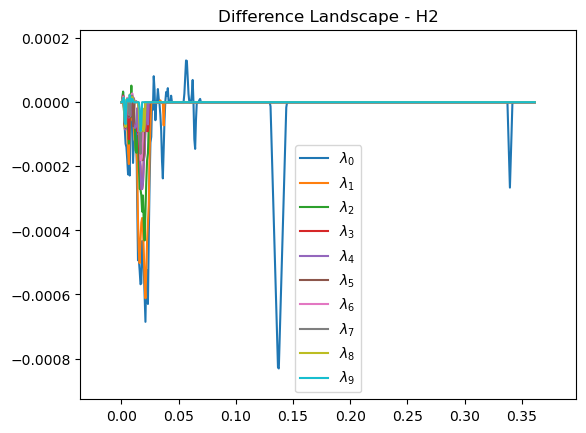

In [9]:
# Plot difference landscape 
if true_diff_pl is not None:
    try:
        plot_landscape_simple(true_diff_pl, title="Difference Landscape - H2", depth_range=range(10))
        
        # uncomment to save the plot
        # diff_plot_path = data_manager.get_output_path("difference_landscape_h2.png", "analysis_results")
        # plt.savefig(diff_plot_path, dpi=200, bbox_inches='tight')
        # print(f"Difference landscape plot saved to: {diff_plot_path.name}")
        
    except Exception as e:
        print(f"Error plotting difference landscape: {e}")
else:
    print("No difference landscape to plot.")

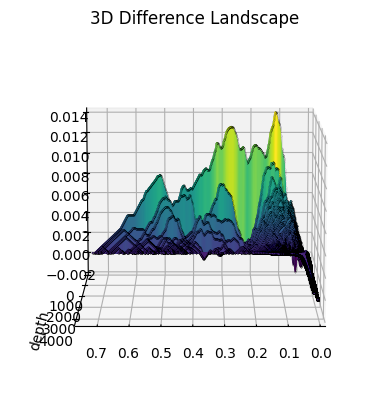

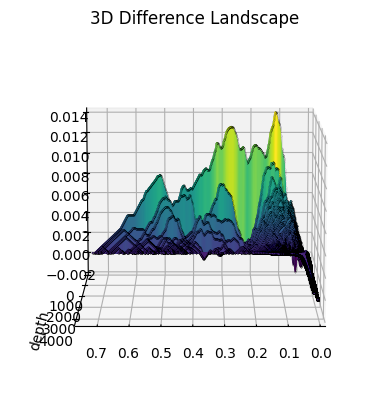

In [ ]:
# Plot 3D difference landscape
if true_diff_pl is not None:
    try:
        plot_landscape(true_diff_pl, title="3D Difference Landscape")
        
        # uncomment to save the 3D plot
        # diff_3d_plot_path = data_manager.get_output_path("difference_landscape_3d.png", "analysis_results")
        # plt.savefig(diff_3d_plot_path, dpi=200, bbox_inches='tight')
        # print(f"3D difference landscape plot saved to: {diff_3d_plot_path.name}")
        
    except Exception as e:
        print(f"Error plotting 3D difference landscape: {e}")
else:
    print("No difference landscape to plot in 3D.")

In [ ]:
# Permutation test - statistical significance analysis
if available_files and 'LGN_landscape' in locals() and 'V1_landscape' in locals() and significance is not None:
    
    # Params for permutation test
    num_pts = 1000
    num_runs = min(10, len(LGN_landscape) + len(V1_landscape))
    num_perms = 1000
    
    try:
        # Combine all landscapes for permutation
        comb_pl = LGN_landscape + V1_landscape
        sig_count = 0
        
        print(f"  Total landscapes: {len(comb_pl)}")
        print(f"  Permutations: {num_perms}")
        print(f"  Target significance: {significance:.6f}")
        
        for shuffle in range(num_perms):
            if shuffle % 100 == 0:
                print(f"    Progress: {shuffle}/{num_perms}")
            
            # Random partition
            A_indices = random.sample(range(len(comb_pl)), num_runs)
            B_indices = [i for i in range(len(comb_pl)) if i not in A_indices]
            
            A_pl = [comb_pl[i] for i in A_indices]
            B_pl = [comb_pl[j] for j in B_indices[:num_runs]]  # Balance the groups
            
            if len(A_pl) > 0 and len(B_pl) > 0:
                A_avg = average_approx(A_pl)
                B_avg = average_approx(B_pl)
                [A_avg_sn, B_avg_sn] = snap_pl([A_avg, B_avg])
                
                shuff_diff = A_avg_sn - B_avg_sn
                if shuff_diff.sup_norm() >= significance:
                    sig_count += 1
        
        pval = sig_count / num_perms
        
        print(f"Permunation test Results:")
        print(f"  Significant shuffles: {sig_count}/{num_perms}")
        print(f"  p-value: {pval:.6f}")

        
        # uncomment to save results
        # results_dict = {
        #     'significance': significance,
        #     'p_value': pval,
        #     'sig_count': sig_count,
        #     'num_perms': num_perms,
        #     'num_landscapes_lgn': len(LGN_landscape),
        #     'num_landscapes_v1': len(V1_landscape)
        # }
        
        # results_path = data_manager.get_output_path("permutation_test_results.pkl", "analysis_results")
        # with open(results_path, 'wb') as f:
        #     pkl.dump(results_dict, f)
        # print(f"Permutation test results saved to: {results_path.name}")
        
    except Exception as e:
        print(f"Error in permutation test: {e}")
        import traceback
        traceback.print_exc()

else:
    print("Insufficient data for permutation test.")

## By Stimulus

In [10]:
if available_files:
    hom_deg = 1  # homology group rank 
    target_dimension = "3d"  # dimension filter
    
    # filter files by dimension and organize by region and stimulus
    stimulus_files = {
        'LGN': {'cex': [], 'lf': [], 'dg': [], 'cg': []},
        'V1': {'cex': [], 'lf': [], 'dg': [], 'cg': []}
    }
    
    for file_path in available_files:
        info = data_manager.parse_filename_info(file_path)
        
        # filter by dimension
        if info['dimension'] != target_dimension:
            continue
        
        region = info['region']
        stimulus = info['stimulus']
        
        # map stimulus names to codes
        stim_code_map = {
            'color_exchange': 'cex',
            'luminance_flash': 'lf',
            'drifting_gratings': 'dg', 
            'chromatic_gratings': 'cg'
        }
        
        stim_code = stim_code_map.get(stimulus, stimulus)
        
        if region in stimulus_files and stim_code in stimulus_files[region]:
            stimulus_files[region][stim_code].append(file_path.name)
    
    print(f"\nFiles found by stimulus:")
    for region in ['LGN', 'V1']:
        print(f"  {region}:")
        for stim_code, files in stimulus_files[region].items():
            stim_name = stim_map.get(stim_code, stim_code)
            print(f"    {stim_name}: {len(files)} files")
    
else:
    print("No files available for stimulus analysis.")


Files found by stimulus:
  LGN:
    color_exchange: 2 files
    luminance_flash: 0 files
    drifting_gratings: 0 files
    chromatic_gratings: 0 files
  V1:
    color_exchange: 10 files
    luminance_flash: 0 files
    drifting_gratings: 0 files
    chromatic_gratings: 0 files


In [11]:
# persistence landscapes by stimulus
if available_files and 'stimulus_files' in locals():
    
    # initialize landscape collections
    landscape_collections = {
        'LGN': {'CEX': [], 'LF': [], 'DG': [], 'CG': []},
        'V1': {'CEX': [], 'LF': [], 'DG': [], 'CG': []}
    }
    
    stim_code_to_label = {'cex': 'CEX', 'lf': 'LF', 'dg': 'DG', 'cg': 'CG'}
    
    for region in ['LGN', 'V1']:
        for stim_code, files in stimulus_files[region].items():
            stim_label = stim_code_to_label.get(stim_code, stim_code.upper())
            landscapes = []
            
            for fname in files:
                try:
                    fpath = data_dir / fname
                    dgms = load_dgms(fpath)
                    
                    if isinstance(dgms, np.ndarray):
                        dgms = dgms.tolist()
                    
                    if dgms and len(dgms) > hom_deg:
                        if dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                            persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                            landscapes.append(persistence_landscape)
                except Exception as e:
                    print(f"    Error processing {fname}: {e}")
                    continue
            
            landscape_collections[region][stim_label] = landscapes
            print(f"  {region} {stim_label}: {len(landscapes)} landscapes")
    
    # average landscapes
    avg_landscapes = {
        'LGN': {},
        'V1': {}
    }
    
    for region in ['LGN', 'V1']:
        for stim_label, landscapes in landscape_collections[region].items():
            if landscapes:
                try:
                    avg_landscapes[region][stim_label] = average_approx(landscapes)
                except Exception as e:
                    print(f" Error computing {region} {stim_label} average: {e}")
                    avg_landscapes[region][stim_label] = None
            else:
                avg_landscapes[region][stim_label] = None
    
else:
    print("No data available for stimulus landscape computation.")

  LGN CEX: 2 landscapes
  LGN LF: 0 landscapes
  LGN DG: 0 landscapes
  LGN CG: 0 landscapes
  V1 CEX: 10 landscapes
  V1 LF: 0 landscapes
  V1 DG: 0 landscapes
  V1 CG: 0 landscapes


In [ ]:
# add plot for stimulus landscapes here